# Entropic Flow Matching for Optimal Time Scheduling


---

**Entropic Time Schedulers on Diffusion Models**:   

Inspired by the work of Stancevic, D., & Handke F., & Ambrogioni, L. (2025). *Entropic Time Schedulers for Generative Diffusion Models*.

---

We expand the work with a standard flow matching implementation and then augment it to estimate entropy production. #

This entropy rate is then used to create an optimized, data-dependent time-stepping schedule for the generative process. 

Approach benefits:

- Improves inference performance
- Prevents oversampling of less-informative time steps
- Prevents undersampling of critical time windows
- Sample-eficient way to generate data
- Easily adapted into any model architecture leveraging flow-matching

In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_moons

## Model Creation
Here we define a simple 4 layer MLP and define our optimizer

In [2]:
dim = 2
hidden_size = 64
batch_size = 2048
model = torch.nn.Sequential(
    torch.nn.Linear(dim + 1, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.SELU(),
    torch.nn.Linear(hidden_size, dim),
)
optimizer = torch.optim.Adam(model.parameters())

In [3]:
from bionemo.moco.distributions.prior import GaussianPrior
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.interpolants import ContinuousFlowMatcher


uniform_time = UniformTimeDistribution()
simple_prior = GaussianPrior()
sigma = 0.1
cfm = ContinuousFlowMatcher(
    time_distribution=uniform_time, prior_distribution=simple_prior, sigma=sigma, prediction_type="velocity"
)
# Place both the model and the interpolant on the same device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
cfm = cfm.to_device(DEVICE)

## Target Data

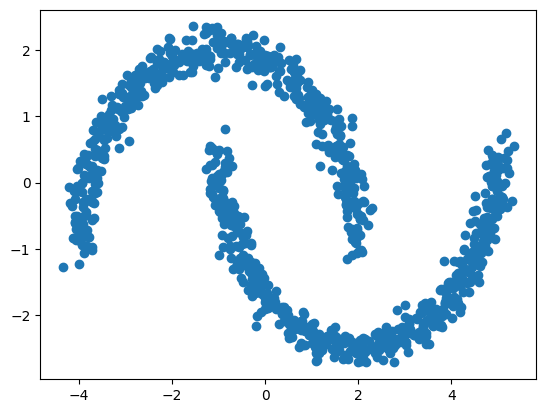

In [4]:
normalize = True


def sample_moons(n, normalize=False):
    x1, _ = make_moons(n_samples=n, noise=0.05)
    x1 = torch.Tensor(x1)
    x1 = x1 * 3 - 1
    if normalize:
        x1 = (x1 - x1.mean(0)) / x1.std(0) * 2
    return x1


x1 = sample_moons(1000)
plt.scatter(x1[:, 0], x1[:, 1])

# Training

In [5]:
for k in range(10_000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = cfm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = cfm.sample_time(batch_size)
    xt = cfm.interpolate(x1, t, x0)
    ut = cfm.calculate_target(x1, x0)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = cfm.loss(vt, ut, target_type="velocity").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 500 == 0:
        print(f"{k + 1}: loss {loss.item():0.3f}")

500: loss 2.972
1000: loss 3.096
1500: loss 2.824
2000: loss 2.925
2500: loss 2.930
3000: loss 2.835
3500: loss 2.935
4000: loss 2.947
4500: loss 3.071
5000: loss 2.917
5500: loss 2.819
6000: loss 2.932
6500: loss 3.018
7000: loss 2.756
7500: loss 2.891
8000: loss 2.871
8500: loss 2.895
9000: loss 2.839
9500: loss 2.931
10000: loss 2.910


## Linear Inference Schedule Example

In [6]:
import matplotlib.pyplot as plt
import torch

from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule, TimeDirection

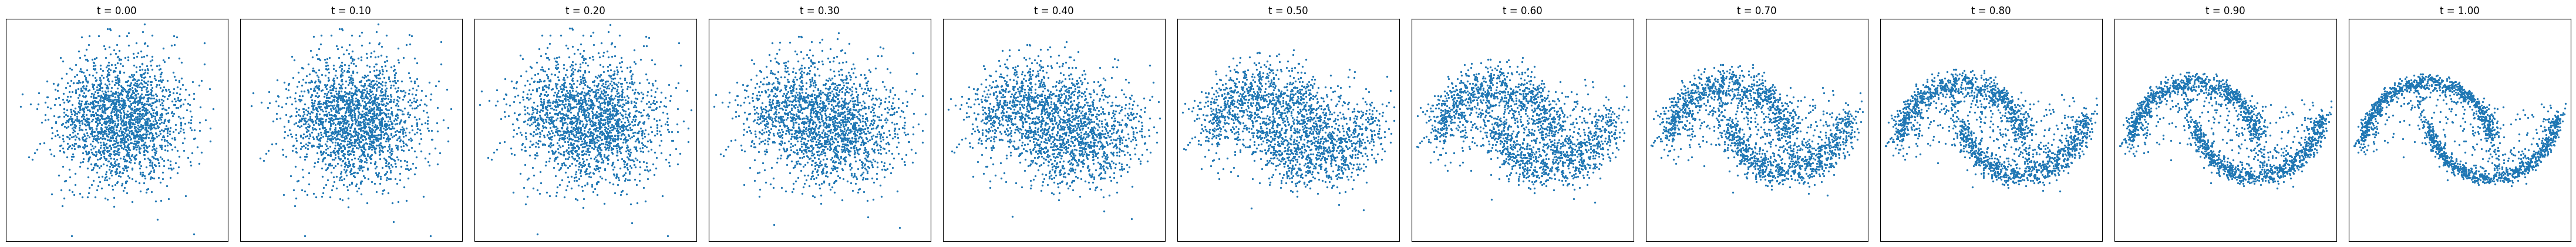

CPU times: user 522 ms, sys: 37.2 ms, total: 559 ms
Wall time: 260 ms


In [7]:
%%time
# ---------- parameters ----------
dim = 2
shape = (batch_size, dim)
_FLOW_STEPS = 100  # number of steps
display_int = 10  # show every n-th step
# --------------------------------


def square_centre_limits(ax, pts, pad_frac: float = 0.05):
    """Make the axes square and centred on the data.

    Args:
        ax  : Matplotlib axis.
        pts : (N, 2) tensor or ndarray on CPU.
        pad_frac: Fractional padding added to the half-range.
    """
    x, y = pts[:, 0], pts[:, 1]
    x_mid, y_mid = (x.max() + x.min()) / 2, (y.max() + y.min()) / 2
    half_range = max(x.max() - x.min(), y.max() - y.min()) / 2
    half_range *= 1 + pad_frac  # add a small margin
    ax.set_xlim(x_mid - half_range, x_mid + half_range)
    ax.set_ylim(y_mid - half_range, y_mid + half_range)


# define schedule
inference_sched = LinearInferenceSchedule(nsteps=_FLOW_STEPS, direction=TimeDirection.UNIFIED)
schedule = inference_sched.generate_schedule().to(DEVICE)  # len = _FLOW_STEPS
dts = inference_sched.discretize().to(DEVICE)  # len = _FLOW_STEPS

# always show t=0 and t=1
display_indices = sorted(set(range(0, _FLOW_STEPS + 1, display_int)) | {0, _FLOW_STEPS})
n_plots = len(display_indices)

with torch.no_grad():
    # start from the prior used in training
    x = cfm.sample_prior(shape).to(DEVICE)

    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
    for ax in axes:
        ax.set_aspect("equal", "box")
        ax.set_xticks([])
        ax.set_yticks([])

    plot_idx = 0
    axes[plot_idx].scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=2)
    axes[plot_idx].set_title("t = 0.00")
    square_centre_limits(axes[plot_idx], x.cpu())

    # sampling loop
    for step, (dt, t) in enumerate(zip(dts, schedule)):
        full_t = inference_sched.pad_time(batch_size, t, device=DEVICE)
        v_t = model(torch.cat([x, full_t[:, None]], dim=-1))
        x = cfm.step(v_t, x, dt, t=full_t)

        # time after the step (always exists, even at the very end)
        t_next = (t + dt).item()

        if (step + 1) in display_indices:
            plot_idx += 1
            ax = axes[plot_idx]
            ax.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=2)
            ax.set_title(f"t = {t_next:.2f}")
            square_centre_limits(ax, x.cpu())

plt.tight_layout(pad=0.8)
plt.show()

# Entropic Time Scheduler


In [43]:
import matplotlib.pyplot as plt
import torch
from torch import Tensor

from bionemo.moco.schedules.inference_time_schedules import EntropicInferenceSchedule, TimeDirection

Generating entropic schedule...
Schedule generated.


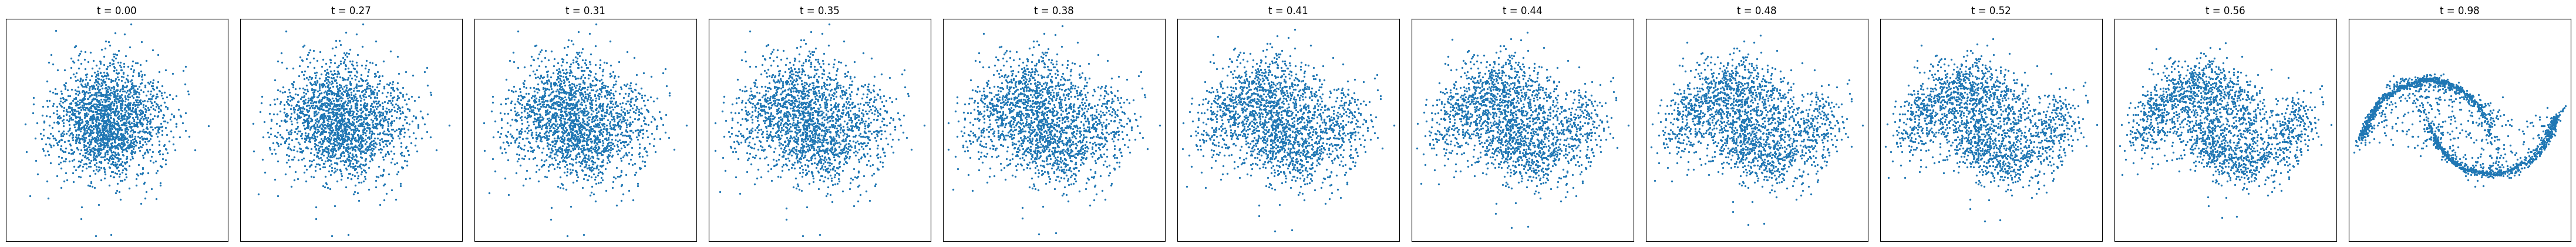

CPU times: user 712 ms, sys: 156 ms, total: 869 ms
Wall time: 524 ms


In [46]:
%%time
_FLOW_STEPS = 100
display_int = 10  # controls every "n" steps to display
shape = (batch_size, dim)


# Predictor function wrapper.
# The scheduler needs a function `model(t, x)` and this wrapper handles the formatting.
def predictor_fn(t: Tensor, x: Tensor) -> Tensor:
    # Ensure t is broadcastable for concatenation
    if t.ndim == 1:
        t = t.unsqueeze(-1)
    if t.shape[0] != x.shape[0]:
        t = t.expand(x.shape[0], -1)

    model_input = torch.cat([x, t], dim=-1)
    return model(model_input)


def x_0_sampler_fn(n_samples: int) -> Tensor:
    return cfm.sample_prior((n_samples, dim))


def x_1_sampler_fn(n_samples: int) -> Tensor:
    return sample_moons(n_samples)


inference_sched = EntropicInferenceSchedule(
    predictor=predictor_fn,
    x_0_sampler=x_0_sampler_fn,
    x_1_sampler=x_1_sampler_fn,
    nsteps=_FLOW_STEPS,
    n_approx_entropy_points=30,  # More points -> more accurate schedule, but slower to generate
    batch_size=batch_size,
    direction=TimeDirection.UNIFIED,
    device=DEVICE,
)
print("Generating entropic schedule...")
schedule = inference_sched.generate_schedule().to(DEVICE)
dts = inference_sched.discretize().to(DEVICE)
print("Schedule generated.")

display_indices = sorted(set(range(0, _FLOW_STEPS + 1, display_int)) | {0, _FLOW_STEPS})
n_plots = len(display_indices)

with torch.no_grad():
    x = cfm.sample_prior((batch_size, dim)).to(DEVICE)

    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
    for ax in axes:
        ax.set_aspect("equal", "box")
        ax.set_xticks([])
        ax.set_yticks([])

    plot_idx = 0
    axes[plot_idx].scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=2)
    axes[plot_idx].set_title("t = 0.00")
    square_centre_limits(axes[plot_idx], x.cpu())

    # integration loop & viz
    for step, (dt, t) in enumerate(zip(dts, schedule)):
        full_t = inference_sched.pad_time(batch_size, t, device=DEVICE)
        v_t = model(torch.cat([x, full_t[:, None]], dim=-1))
        x = cfm.step(v_t, x, dt, t=full_t)

        t_next = (t + dt).item()

        if (step + 1) in display_indices:
            plot_idx += 1
            ax = axes[plot_idx]
            ax.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=2)
            ax.set_title(f"t = {t_next:.2f}")
            square_centre_limits(ax, x.cpu())

plt.tight_layout(pad=0.8)
plt.show()